## Data preprocessing

In [1]:
import os
from pathlib import Path
import pandas as pd
import shutil

In [2]:
# INPUT_DIRS
INPUT_DATA_DIR = Path('C:/Users/Reinhard/Documents/computer_vision_projects/amini_cocoa_contamination_challenge')

In [3]:
## Drop the Folder if it already exists
DATASETS_DIR = Path('dataset')
DATASETS_DIR.mkdir(exist_ok=True)

In [4]:
# Defining the dataset paths
TRAIN_IMAGES_DIR = DATASETS_DIR / 'images' /'train'
TRAIN_LABELS_DIR = DATASETS_DIR / 'labels' / 'train'
TEST_IMAGES_DIR = DATASETS_DIR / 'images' / 'test'
VAL_IMAGES_DIR = DATASETS_DIR / 'images' /'val'
VAL_LABELS_DIR = DATASETS_DIR / 'labels' /'val'

In [5]:
# Check if DATASETS_DIR exists, if it does delete it and recreate it
for DIR in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR, VAL_LABELS_DIR, TRAIN_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [6]:
# Unpack the 'dataset.zip'
shutil.unpack_archive(INPUT_DATA_DIR / 'dataset.zip', DATASETS_DIR)

In [7]:
num_train_images = len(os.listdir(TRAIN_IMAGES_DIR))
num_train_labels = len(os.listdir(TRAIN_LABELS_DIR))
num_test_images = len(os.listdir(TEST_IMAGES_DIR))


In [8]:
print(f"✅ Train Images: {num_train_images}")
print(f"✅ Train Labels: {num_train_labels}")
print(f"✅ Test Images: {num_test_images}")


✅ Train Images: 5529
✅ Train Labels: 5529
✅ Test Images: 1626


In [10]:
# checking whether all the images have corresponding labels
train_images_stems = set(Path(img).stem for img in os.listdir(TRAIN_IMAGES_DIR))
train_labels_stems = set(Path(lbl).stem for lbl in os.listdir(TRAIN_LABELS_DIR))

In [11]:
missing_labels = train_images_stems  - train_labels_stems
missing_images = train_labels_stems - train_images_stems

In [12]:
print(f"❌ Images without labels: {len(missing_labels)}")
print(f"❌ Labels without images: {len(missing_images)}")


❌ Images without labels: 0
❌ Labels without images: 0


## Inspecting the class distribution

In [13]:
train_csv_path = DATASETS_DIR.parent / 'Train.csv'

if train_csv_path.exists():
    train_df = pd.read_csv(train_csv_path)
    # check unique classes
    class_counts = train_df['class'].value_counts()
    print(f"✅ Disease class distribution:\n", class_counts)
    #Create a class mapping dictionary
    class_map = {cls:i for i, cls in enumerate(sorted(train_df['class'].unique()))}
    print(f"✅ Class mapping:\n", class_map)

else:
    print("❌ Train.csv not found")


✅ Disease class distribution:
 class
healthy        4280
cssvd          3241
anthracnose    2271
Name: count, dtype: int64
✅ Class mapping:
 {'anthracnose': 0, 'cssvd': 1, 'healthy': 2}


## Visualizing sample images with Bounding boxes

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [15]:
#Function to load the bounding boxes
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

In [16]:
# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, label_path):
    image = np.array(Image.open(str(image_path)))

    # Get image dimensions
    h, w , _ = image.shape

    #load bounding boxes
    boxes = load_annotations(label_path)

    # Plot the image
    plt.figure(figsize=(10,10))
    plt.imshow(image)

    #Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box

        # Convert YOLO format to pixel coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2 ) * h)
        xmax = int((x_center + width / 2 ) * w)
        ymax = int((y_center + height / 2 ) * h)

        # Draw bounding box 
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none'))
        plt.text(xmin, ymin-10, f'class {int(class_id)}', color='red', fontsize=8, weight='bold')
    plt.axis('off')
    plt.show()


In [17]:
sample_image_name = os.listdir(TRAIN_IMAGES_DIR)[0]
image_path = TRAIN_IMAGES_DIR / sample_image_name
label_path = TRAIN_LABELS_DIR / (Path(sample_image_name).stem + '.txt')     

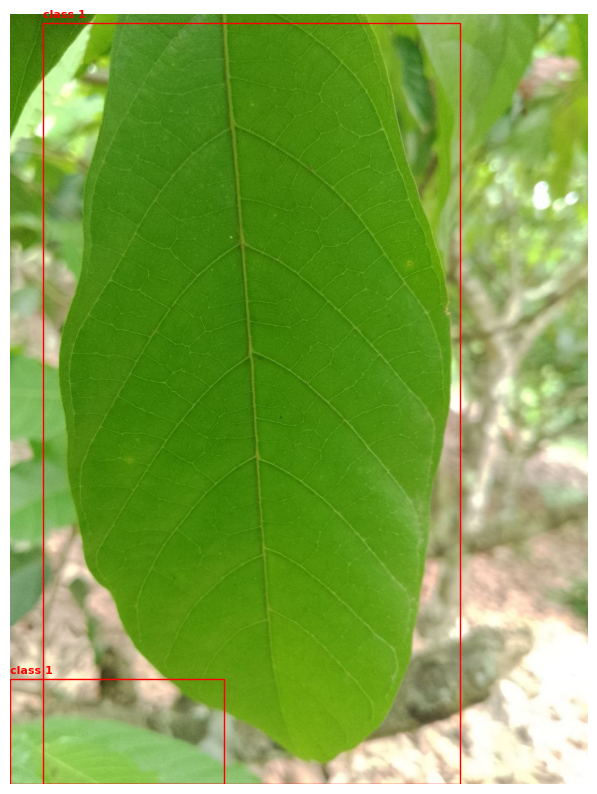

In [18]:
# check if label exists before plotting
if label_path.exists():
    plot_image_with_boxes(image_path, label_path)
else:
    print(f"❌ {label_path} not found")

## Data preprocessing (Handling imbalance and Augmentation)

In [20]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import shutil
import random

In [23]:
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    ToTensorV2()
])

In [24]:
#Paths to augmented data
AUGMENTED_IMAGES_DIR = DATASETS_DIR / 'images' / 'train_augmented'
AUGMENTED_LABELS_DIR = DATASETS_DIR / 'labels' / 'train_augmented'
AUGMENTED_IMAGES_DIR.mkdir(parents=True, exist_ok=True) 
AUGMENTED_LABELS_DIR.mkdir(parents=True, exist_ok=True)

In [25]:
class_map = {'healthy': 0, 'cssvd': 1, 'anthracnose': 2}

In [26]:
#Augment underrepresented classes
def augment_class(target_class, num_extra):
    class_images = [img for img in os.listdir(TRAIN_IMAGES_DIR) if target_class in img]
    random.shuffle(class_images)
    
    count = 0
    for img_name in class_images:
        if count >= num_extra:
            break

        img_path = TRAIN_IMAGES_DIR / img_name
        label_path = TRAIN_LABELS_DIR / (Path(img_name).stem + '.txt')

        if not label_path.exists():
            continue  # skip the images without labels

        # Read image
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #Load bounding boxes
        boxes = load_annotations(label_path)
        annotations = []
        for box in boxes:
            class_id, x, y, w, h  = box
            annotations.append({'class': class_id, 'bbox': [x,y,w,h]})

        # Apply augmentation
        transformed = augmentations(image=image) 
        aug_image = transformed['image']

        #save augmented image
        new_img_name = f'aug_{count}_{img_name}'
        aug_img_path = AUGMENTED_IMAGES_DIR / new_img_name
        cv2.imwrite(str(aug_img_path), aug_image.numpy().transpose(1,2,0)[:, :, ::-1])
        
        #save label file
        new_label_path = AUGMENTED_LABELS_DIR / (Path(new_img_name).stem + '.txt')
        shutil.copy(label_path, new_label_path)

        count += 1



#Augment CSSVD (Generate approx 1000 new images)
augment_class('cssvd', num_extra=1000)

#ugment Anthracnose (Generate approc 2000 images)
augment_class('anthracnose', num_extra=2000)

print("✅ Augmentation completed!")





✅ Augmentation completed!


In [27]:
# Define preprocessing transformation
preprocessing = A.Compose([
    A.Resize(640, 640),  # Resize to 640x640 for YOLOv8
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize
    ToTensorV2()
])

def preprocess_image(image_path):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = preprocessing(image=image)
    return transformed["image"]

# Apply preprocessing to all images
for img_name in os.listdir(TRAIN_IMAGES_DIR):
    img_path = TRAIN_IMAGES_DIR / img_name
    processed_image = preprocess_image(img_path)

print("✅ Preprocessing completed!")



✅ Preprocessing completed!


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import numpy as np
from pathlib import Path
import shutil

# Paths
DATASETS_DIR = Path("dataset")
TRAIN_IMAGES_DIR = DATASETS_DIR / "images" / "train"
TRAIN_LABELS_DIR = DATASETS_DIR / "labels" / "train"

AUGMENTED_IMAGES_DIR = DATASETS_DIR / "images" / "augmented"
AUGMENTED_LABELS_DIR = DATASETS_DIR / "labels" / "augmented"

# Create directories if they don’t exist
AUGMENTED_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
AUGMENTED_LABELS_DIR.mkdir(parents=True, exist_ok=True)
# Albumentations pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3),
    A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.2), rotate=(-10, 10), p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Classes to augment (since healthy is the majority class, we balance cssvd & anthracnose)
TARGET_CLASSES = {"cssvd", "anthracnose"}
AUGMENTATIONS_PER_IMAGE = 3  # Number of augmented copies per image

# Function to augment images
def augment_class(image_name):
    """ Apply augmentation to images of the target classes. """
    img_path = TRAIN_IMAGES_DIR / image_name
    img_ext = image_name.split('.')[-1]
    label_path = TRAIN_LABELS_DIR / image_name.replace(f'.{img_ext}', '.txt')

    # Verify if the label file exists
    if not label_path.exists():
        print(f"[WARNING] Label missing for {image_name}. Skipping.")
        return

    # Load image
    image = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)  # Load image as is
    if image is None:
        print(f"[ERROR] Unable to load image: {img_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    h, w, _ = image.shape

    # Read YOLO format labels
    with open(label_path, "r") as f:
        lines = f.readlines()

    # Parse bounding boxes and classes
    bboxes = []
    class_labels = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        class_id = int(class_id)
        
        # Check if this image contains a target class
        if class_id not in {1, 2}:  # Assuming class 1 = cssvd, class 2 = anthracnose
            return  # Skip augmentation for "healthy" images
        
        bboxes.append([x_center, y_center, width, height])
        class_labels.append(class_id)

    print(f"[INFO] Augmenting {image_name} with {len(bboxes)} bounding boxes.")


    # Generate augmented images
    for i in range(AUGMENTATIONS_PER_IMAGE):
        augmented = augmentation(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented["image"]
        aug_bboxes = [[max(0.0, mi`n(coord, 1.0)) for coord in bbox] for bbox in augmented["bboxes"]]  # Ensure bbox values are within [0,1]
        aug_labels = augmented["class_labels"]

        # Save augmented image
        aug_img_name = f"aug_{i}_{image_name}"
        aug_img_path = AUGMENTED_IMAGES_DIR / aug_img_name
        cv2.imwrite(str(aug_img_path), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        # Save augmented labels
        aug_label_name = f"aug_{i}_{image_name.replace(f'.{img_ext}', '.txt')}"
        aug_label_path = AUGMENTED_LABELS_DIR / aug_label_name
        with open(aug_label_path, "w") as f:
            for bbox, cls in zip(aug_bboxes, aug_labels):
                bbox = np.clip(bbox, 0.0, 1.0)  # Extra safety check
                f.write(f"{cls} {' '.join(map(str, bbox))}\n")

    print(f"[SUCCESS] Saved: {aug_img_name} and {aug_label_name}")
# Process images in the training set
for img_file in os.listdir(TRAIN_IMAGES_DIR):
    print(f"Processing: {img_file}")
    try:
        augment_class(img_file)
    except Exception as e:
        print(f"Error in {img_file}: {e}")


# Verify counts after augmentation
num_aug_images = len(os.listdir(AUGMENTED_IMAGES_DIR))
num_aug_labels = len(os.listdir(AUGMENTED_LABELS_DIR))
print(f"\n✅ Augmentation Complete: {num_aug_images} images, {num_aug_labels} labels generated.")


Processing: ID_a0M4cn.jpg
[INFO] Augmenting ID_a0M4cn.jpg with 2 bounding boxes.
[SUCCESS] Saved: aug_2_ID_a0M4cn.jpg and aug_2_ID_a0M4cn.txt
Processing: ID_A0o1FA.jpeg
[INFO] Augmenting ID_A0o1FA.jpeg with 1 bounding boxes.
[SUCCESS] Saved: aug_2_ID_A0o1FA.jpeg and aug_2_ID_A0o1FA.txt
Processing: ID_a0X1kg.jpg
Processing: ID_A1OsZt.jpeg
[INFO] Augmenting ID_A1OsZt.jpeg with 1 bounding boxes.
[SUCCESS] Saved: aug_2_ID_A1OsZt.jpeg and aug_2_ID_A1OsZt.txt
Processing: ID_a2eocv.jpg
[INFO] Augmenting ID_a2eocv.jpg with 1 bounding boxes.
[SUCCESS] Saved: aug_2_ID_a2eocv.jpg and aug_2_ID_a2eocv.txt
Processing: ID_a2zxFb.jpg
[INFO] Augmenting ID_a2zxFb.jpg with 1 bounding boxes.
[SUCCESS] Saved: aug_2_ID_a2zxFb.jpg and aug_2_ID_a2zxFb.txt
Processing: ID_a34fvU.jpg
[INFO] Augmenting ID_a34fvU.jpg with 6 bounding boxes.
[SUCCESS] Saved: aug_2_ID_a34fvU.jpg and aug_2_ID_a34fvU.txt
Processing: ID_A397lM.jpg
[INFO] Augmenting ID_A397lM.jpg with 1 bounding boxes.
Error in ID_A397lM.jpg: Expected x_

## Splitting the dataset into training and validation sets 

In [29]:
import os
import shutil
import random


In [39]:
AUGMENTED_IMAGES_DIR = 'C:/Users/Reinhard/Documents/computer_vision_projects/amini_cocoa_contamination_challenge/dataset/images/augmented'
AUGMENTED_LABELS_DIR = 'C:/Users/Reinhard/Documents/computer_vision_projects/amini_cocoa_contamination_challenge/dataset/labels/augmented'

In [42]:
len(os.listdir(AUGMENTED_LABELS_DIR))

10440

In [45]:
from PIL import Image
import os
from collections import defaultdict

In [47]:
folder_path = AUGMENTED_IMAGES_DIR
image_counts = defaultdict(int)


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    if os.path.isfile(file_path):
        ext = filename.lower().split('.')[-1]  # Get file extension (lowercase)
        try:
            with Image.open(file_path) as img:
                if ext in ["jpg", "jpeg", "png", "gif", "bmp", "tiff", "webp"]:
                    image_counts[ext] += 1  # Count based on extension
                else:
                    image_counts["Unknown"] += 1
        except:
            image_counts["Corrupt or Not an Image"] += 1

# Print results
for img_type, count in image_counts.items():
    print(f"{img_type.upper()}: {count}")

JPG: 7803
JPEG: 2637


In [53]:
TRAIN_DIR = "dataset/train"
VAL_DIR = "dataset/val"


In [54]:
for split in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(os.path.join(split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(split, 'labels'), exist_ok=True)

In [55]:
all_images = [f for f in os.listdir(AUGMENTED_IMAGES_DIR) if f.lower().endswith((".jpg", ".jpeg"))]
random.shuffle(all_images)  # Shuffle to randomize selection


In [56]:
len(all_images)

10440

In [57]:
#Split sizes
train_split = int(0.9 * len(all_images))


In [58]:
# Assign images to splits
train_files = all_images[:train_split]
val_files = all_images[train_split:]

In [60]:
def move_files(file_list, dest_dir):
    for file in file_list:
        img_src = os.path.join(AUGMENTED_IMAGES_DIR, file)
        img_dst = os.path.join(dest_dir, 'images', file)

        #Handle both jpg and jpeg extensions for label files
        if file.lower().endswith(".jpg"):
            lbl_src = os.path.join(AUGMENTED_LABELS_DIR, file.replace(".jpg", ".txt"))
            lbl_dst = os.path.join(dest_dir, "labels", file.replace(".jpg", ".txt"))
        elif file.lower().endswith(".jpeg"):
            lbl_src = os.path.join(AUGMENTED_LABELS_DIR, file.replace(".jpeg", ".txt"))
            lbl_dst = os.path.join(dest_dir, "labels", file.replace(".jpeg", ".txt"))
        else:
            continue  # Skip non-JPG/JPEG files

        # Move image and label files
        shutil.move(img_src, img_dst)
        if os.path.exists(lbl_src):  # Ensure label file exists before moving
            shutil.move(lbl_src, lbl_dst)

In [61]:
move_files(train_files, TRAIN_DIR)
move_files(val_files, VAL_DIR)

In [62]:
print(f"Dataset split complete!\nTrain: {len(train_files)} images\nValidation: {len(val_files)} images")


Dataset split complete!
Train: 9396 images
Validation: 1044 images


## Model selection and training strategy

In [64]:
from ultralytics import YOLO
import yaml

In [ ]:
data_yaml = {
    "path" : str(DATASETS_DIR.absolute()),
    'train': str(TRAIN_IMAGES_DIR.absolute()),
    'val': str(VAL_IMAGES_DIR.absolute()),
    'test': str(TEST_IMAGES_DIR.absolute()),
    'nc': 3,
    'names': ['healthy', 'cssvd', 'anthracnose']
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml